## Fundamental questions on implementation of Frechet Mean in Geomstats

### Q1 Please take a look at the Gradient Descent loop implementation as below and check the metric_dim variable definition.  


### Q2 The Frechet Mean calculated will never be truly accurate or converged. Please analyze if the below definition for metric_dim would be appropriate? This is only when the metric used is SRV Metric.

### Calculating Frechet Mean of a set of curves. Scroll down for Q3.

In [4]:
import warnings
import matplotlib.pyplot as plt
import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
import pandas as pd
from geomstats.geometry.pre_shape import PreShapeSpace
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric
from geomstats.learning.frechet_mean import FrechetMean

warnings.filterwarnings("ignore")
gs.random.seed(2021)

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)

LINES = gs.unique(lines)
print(LINES)

INFO: Using numpy backend


Total number of cells : 650
['control' 'cytd' 'jasp']
['dlm8' 'dunn']


In [7]:
ds = {}
n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

# display(n_cells_df)
len(ds["cytd"]["dlm8"])

def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds


def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
                curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


N_SAMPLING_POINTS = 100

cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, N_SAMPLING_POINTS)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


In [8]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, N_SAMPLING_POINTS)
)

In [9]:
M_AMBIENT = 2
PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=N_SAMPLING_POINTS)
PRESHAPE_METRIC = PRESHAPE_SPACE.embedding_metric


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)

    vector_1 = curve[1] - curve[0]
    vector_2 = base_curve[1] - base_curve[0]
    dot_product = gs.dot(vector_1, vector_2)

    if dot_product < 0:
        curve = curve[::-1]

    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.align(point=reparametrized, base_point=base_curve)
        distances[shift] = PRESHAPE_METRIC.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.align(
        point=reparametrized_min, base_point=base_curve
    )
    return aligned_curve


ds_proj = apply_func_to_ds(ds_interp, func=PRESHAPE_SPACE.projection)
print(ds_proj["control"]["dunn"].shape)

BASE_CURVE = ds_proj["control"]["dunn"][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
print(ds_align["control"]["dunn"].shape)

(204, 100, 2)
Shape of BASE_CURVE: (100, 2)
(204, 100, 2)


In [10]:
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.square_root_velocity_metric

cell_shapes_list = []
for treatment in TREATMENTS:
    for line in LINES:
        cell_shapes_list.extend(ds_align[treatment][line])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(650, 100, 2)


### Q3 While calculating Frechet Mean of 200 curves as below the calculation breaks as there are several NaNs in the mean_estimate. But calculating the Frechet mean for the first 151 curves doesn't generate any issues.

### Frechet Mean calculation for first 200 curves

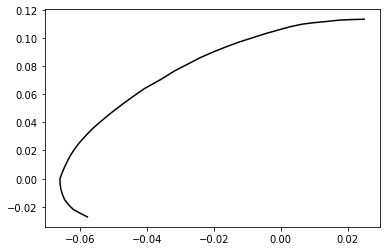

In [11]:
mean = FrechetMean(metric=SRV_METRIC, point_type="matrix", method="default")
mean.fit(cell_shapes[:200])
mean_estimate = mean.estimate_
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black")

### Frechet Mean calculation for first 151 curves

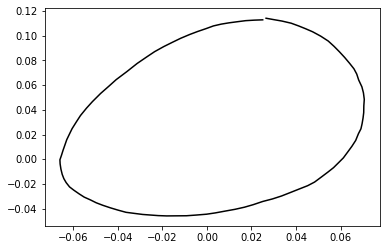

In [32]:
mean = FrechetMean(metric=SRV_METRIC, point_type="matrix", method="default")
mean.fit(cell_shapes[:151])
mean_estimate = mean.estimate_
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black")

### Only on including the 152th curve in the calculation, the Frechet Mean generation fails !

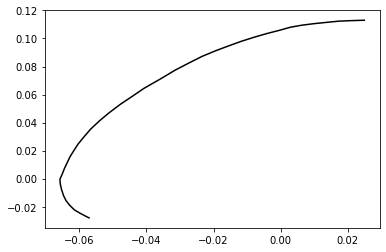

In [33]:
mean = FrechetMean(metric=SRV_METRIC, point_type="matrix", method="default")
mean.fit(cell_shapes[:152])
mean_estimate = mean.estimate_
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black")

### Let's look at the cell shape for the 151th and 152th curve 

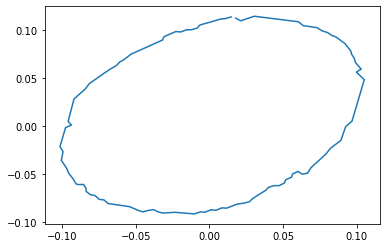

In [35]:
plt.plot(cell_shapes[150][:, 0], cell_shapes[150][:, 1])

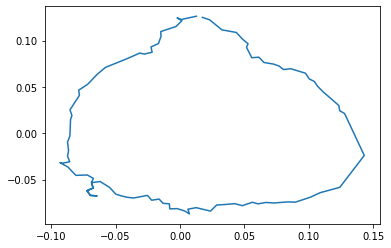

In [36]:
plt.plot(cell_shapes[151][:, 0], cell_shapes[151][:, 1])

### Frechet Mean for 151th cell shape with itself

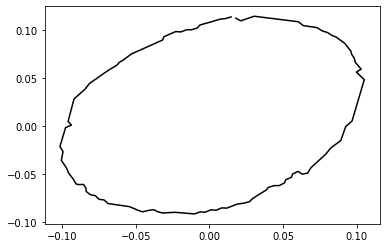

In [38]:
random_index_1 = 150
random_cell_1 = cell_shapes[random_index_1]

random_index_2 = 150
random_cell_2 = cell_shapes[random_index_2]

small_cell_shapes_list = [random_cell_1, random_cell_2]
small_cell_shapes = gs.array(small_cell_shapes_list)

mean = FrechetMean(metric=SRV_METRIC, point_type="matrix", method="default")
mean.fit(small_cell_shapes)
mean_estimate = mean.estimate_

plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black")

### Frechet Mean for 152th cell shape with itself

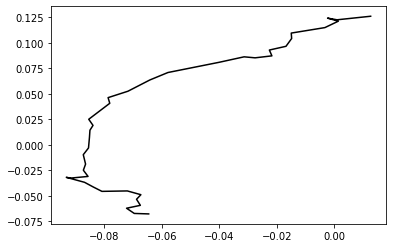

In [40]:
random_index_1 = 151
random_cell_1 = cell_shapes[random_index_1]

random_index_2 = 151
random_cell_2 = cell_shapes[random_index_2]

small_cell_shapes_list = [random_cell_1, random_cell_2]
small_cell_shapes = gs.array(small_cell_shapes_list)

mean = FrechetMean(metric=SRV_METRIC, point_type="matrix", method="default")
mean.fit(small_cell_shapes)
mean_estimate = mean.estimate_

plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black")